In [15]:
# Imports
import os
import pickle
import pandas as pd
from datetime import datetime
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Constants and Vars
TC_CSX = {'hp': 158, 'torque': 139, 'mass':1313}
TC = TC_CSX
hpmratio = TC['hp'] / TC['mass']
tmratio = TC['torque'] / TC['mass']


DATA_FILE = '26'
DATA_FILES = [26,27,28,31,32,33,34,36,37,38,40]
DATA_FOLDER = 'hwd_data2'
FILE_NAME = "{}/run_{}.csv".format(DATA_FOLDER, DATA_FILE)
SAVE_FOLDER = 'hwd_processed'
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [3]:
# df_in = pd.read_csv(FILE_NAME,header=None,sep=',', names=['date', 'speed', 'engine_load','throttle','rpm',
#                                                       'heading', 'roll', 'pitch',
#                                                       'sys', 'gyro', 'accel', 'mag',
#                                                       'magx', 'magy', 'magz',
#                                                       'gyrx', 'gyry', 'gyrz',
#                                                       'linaccx', 'linaccy', 'linaxxz'
#                                                      ])

In [6]:
def format_df(f_name):
    df = pd.read_csv(FILE_NAME,header=None,sep=',', names=['date', 'speed', 'engine_load','throttle','rpm',
                                                      'heading', 'roll', 'pitch',
                                                      'sys', 'gyro', 'accel', 'mag',
                                                      'magx', 'magy', 'magz',
                                                      'gyrx', 'gyry', 'gyrz',
                                                      'linaccx', 'linaccy', 'linaxxz'
                                                     ])
    df['time'] = (df.date - df.date.iloc[0])
    df['time_diff'] = df.time.diff()
    df['speed'] = df.speed.str.replace(' kph','')
    df['engine_load'] = df.engine_load.str.replace(' percent', '')
    df['throttle'] = df.throttle.str.replace(' percent', '')
    df['rpm'] = df.rpm.str.replace(' revolutions_per_minute', '')

    obd2_cols = ['speed', 'engine_load', 'throttle', 'rpm']
    for col in obd2_cols:
        df[col].replace('None', np.nan,inplace=True)
        df[col] = df[col].apply(np.float64)
        df[col] = df[col].interpolate(limit=4,direction='both')
    df = df[1:-1]

    min_throttle = df.throttle.min()
    df['throttle'] = df['throttle'] * (1+0.01*min_throttle) - min_throttle
    df = df[df.speed > 0]

    df['lateral_velocity'] = df.heading.diff() / df.time_diff
    df['speed_diff'] = df.speed.diff()
    df['acc'] = df.speed_diff / df.time_diff
    return df

def calculate_score(score, averaged_score, max_score):
    
    final_score = 0

    if score > averaged_score:
        calculate_difference= (score - averaged_score)/(max_score - averaged_score)
        final_score = 2.5 + 2.5 * calculate_difference
    else:
        final_score = (score/averaged_score * 2.5)
            
    return final_score

In [7]:
# HP
test_df = format_df(FILE_NAME)

#test_df
#test_hp = test_df[test_df.rpm > 2500][test_df.speed_diff >= 0]
#test_hp['hp_score'] = test_hp.speed_diff * test_hp.throttle
#print('HP_SCORE: ',test_hp['hp_score'].mean()/hpmratio)
# Breaking on speed diff??? Then calculate acceleration based on derivative?

2.65401778645


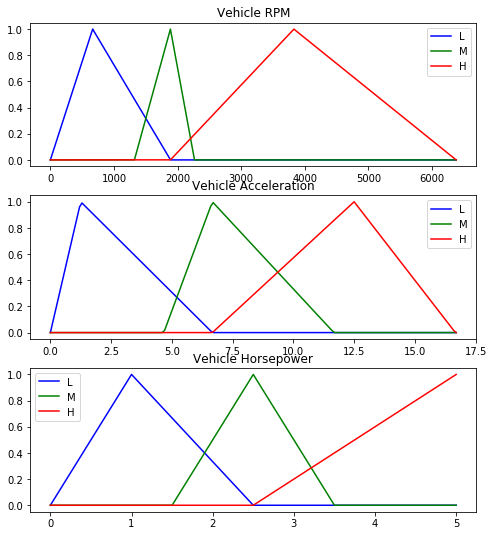

In [9]:
def calculate_horsepower(rpm_input, acc_input):

    average_rpm = test_df['rpm'].median()
    max_rpm = test_df['rpm'].max()
    min_rpm = test_df['rpm'].min()
    
    rpm = np.arange(0, max_rpm + 1, 1)
    rpm_set = ctrl.Antecedent(rpm, 'rpm')

    # Generate fuzzy membership functions
    rpm_lo = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
    rpm_md = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
    rpm_hi = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

    rpm_set['L'] = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
    rpm_set['M'] = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
    rpm_set['H'] = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

    ax0.plot(rpm, rpm_lo, 'b', linewidth=1.5, label='L')
    ax0.plot(rpm, rpm_md, 'g', linewidth=1.5, label='M')
    ax0.plot(rpm, rpm_hi, 'r', linewidth=1.5, label='H')
    ax0.set_title('Vehicle RPM')
    ax0.legend()

    acc_df = test_df[test_df.acc >0]

    average_acc = acc_df['acc'].median()
    max_acc = acc_df['acc'].max()
    min_acc = acc_df['acc'].min()

    acc = np.arange(0, max_acc + 0.1, 0.1)

    acc_set = ctrl.Antecedent(acc, 'acc')

    # Generate fuzzy membership functions
    acc_lo = fuzz.trimf(acc, [0, min_acc, average_acc])
    acc_md = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
    acc_hi = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

    acc_set['L'] = fuzz.trimf(acc, [0, min_acc, average_acc])
    acc_set['M'] = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
    acc_set['H'] = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

    ax1.plot(acc, acc_lo, 'b', linewidth=1.5, label='L')
    ax1.plot(acc, acc_md, 'g', linewidth=1.5, label='M')
    ax1.plot(acc, acc_hi, 'r', linewidth=1.5, label='H')
    ax1.set_title('Vehicle Acceleration')
    ax1.legend()

    HP = np.arange(0, 5.1, 0.1)

    HP_lo = fuzz.trimf(HP, [0, 1, 2.5])
    HP_md = fuzz.trimf(HP, [1.5, 2.5, 3.5])
    HP_hi = fuzz.trimf(HP, [2.5, 5, 5])

    HP_set = ctrl.Consequent(HP, 'HP')

    HP_set['L'] = fuzz.trimf(HP, [0, 1, 2.5])
    HP_set['M'] = fuzz.trimf(HP, [1.5, 2.5, 3.5])
    HP_set['H'] = fuzz.trimf(HP, [2.5, 5, 5])

    ax2.plot(HP, HP_lo, 'b', linewidth=1.5, label='L')
    ax2.plot(HP, HP_md, 'g', linewidth=1.5, label='M')
    ax2.plot(HP, HP_hi, 'r', linewidth=1.5, label='H')
    ax2.set_title('Vehicle Horsepower')
    ax2.legend()


    rule1 = ctrl.Rule(acc_set['L'] & rpm_set['L'], HP_set['L'])
    rule2 = ctrl.Rule(acc_set['L'] & rpm_set['M'], HP_set['M'])
    rule3 = ctrl.Rule(acc_set['L'] & rpm_set['H'], HP_set['H'])

    rule4 = ctrl.Rule(acc_set['M'] & rpm_set['L'], HP_set['L'])
    rule5 = ctrl.Rule(acc_set['M'] & rpm_set['M'], HP_set['H'])
    rule6 = ctrl.Rule(acc_set['M'] & rpm_set['H'], HP_set['H'])

    rule7 = ctrl.Rule(acc_set['H'] & rpm_set['L'], HP_set['L'])
    rule8 = ctrl.Rule(acc_set['H'] & rpm_set['M'], HP_set['H'])
    rule9 = ctrl.Rule(acc_set['H'] & rpm_set['H'], HP_set['H'])

    system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

    HP_output = ctrl.ControlSystemSimulation(system)

    HP_output.input['acc'] = acc_input
    HP_output.input['rpm'] = rpm_input

    HP_output.compute()
    print(HP_output.output['HP'])

calculate_horsepower(2000, 2.5)
        

1.17820509251


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


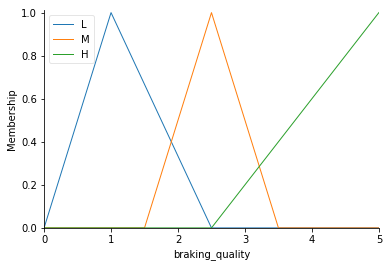

In [10]:
def calculate_braking_score(deacc_average, num_brakes):

    test_df['deacc'] = -1 * test_df[test_df.acc < 0]['acc'] 
    #Invert values so they confuse less 

    average_deacc = test_df['deacc'].mean()
    max_deacc = test_df['deacc'].max()
    min_deacc = test_df['deacc'].min()

    deacc = np.arange(0, max_deacc + 0.1, 0.1)
    deacc_set = ctrl.Antecedent(deacc, 'deacc')
    deacc_set['L'] = fuzz.trimf(deacc, [0, min_deacc, average_deacc])
    deacc_set['M'] = fuzz.trimf(deacc, [0.6 * average_deacc, average_deacc, average_deacc * 1.3])
    deacc_set['H'] = fuzz.trimf(deacc, [average_deacc, max_deacc, max_deacc])

    #Determine number of times

    counter = 0 
    previous_acceleration = 0
    acceleration = 0
    #this variable is for when they start deacceleration (We record when acceleration goes to deacceleration)
    num_of_times_brake_average = 0
    num_of_times_stepped = 0
    acceleration_diff = 0
    error_margin = 1
    previous_acceleration_diff = 0

    for index, row in test_df.iterrows():

        curr_acceleration = row['acc']

        if counter == 0:
            previous_acceleration = curr_acceleration
        else:

            if previous_acceleration > 0 and curr_acceleration < 0:
                num_of_times_brake_average += 1
                num_of_times_stepped += 1

            difference = curr_acceleration - previous_acceleration

            if previous_acceleration_diff < 0 and difference < 0 and difference < (previous_acceleration_diff - error_margin): 
                num_of_times_stepped += 1

            if curr_acceleration < 0 and previous_acceleration < 0:
                previous_acceleration_diff = curr_acceleration - previous_acceleration
            else: 
                previous_acceleration_diff = 0

        previous_acceleration = curr_acceleration
        counter = counter + 1

    braking_steps = np.arange(0, num_of_times_brake_average * 2 + 0.1, 0.1)
    braking_steps_set = ctrl.Antecedent(braking_steps, 'braking_steps')
    braking_steps_set['L'] = fuzz.trimf(braking_steps, [0, num_of_times_brake_average * 0.8, num_of_times_brake_average])
    braking_steps_set['M'] = fuzz.trimf(braking_steps, [0.75 * num_of_times_brake_average, num_of_times_brake_average, num_of_times_brake_average * 1.75])
    braking_steps_set['H'] = fuzz.trimf(braking_steps, [num_of_times_brake_average * 1.25, num_of_times_brake_average * 2, num_of_times_brake_average * 2])


    braking_quality = np.arange(0, 5.1, 0.1)

    braking_quality_set = ctrl.Consequent(braking_quality, 'braking_quality')

    braking_quality_set['L'] = fuzz.trimf(braking_quality, [0, 1, 2.5])
    braking_quality_set['M'] = fuzz.trimf(braking_quality, [1.5, 2.5, 3.5])
    braking_quality_set['H'] = fuzz.trimf(braking_quality, [2.5, 5, 5])

    braking_quality_set.view()

    rule1 = ctrl.Rule(deacc_set['L'] & braking_steps_set['L'], braking_quality_set['H'])
    rule2 = ctrl.Rule(deacc_set['L'] & braking_steps_set['M'], braking_quality_set['M'])
    rule3 = ctrl.Rule(deacc_set['L'] & braking_steps_set['H'], braking_quality_set['L'])

    rule4 = ctrl.Rule(deacc_set['M'] & braking_steps_set['L'], braking_quality_set['H'])
    rule5 = ctrl.Rule(deacc_set['M'] & braking_steps_set['M'], braking_quality_set['M'])
    rule6 = ctrl.Rule(deacc_set['M'] & braking_steps_set['H'], braking_quality_set['L'])

    rule7 = ctrl.Rule(deacc_set['H'] & braking_steps_set['L'], braking_quality_set['H'])
    rule8 = ctrl.Rule(deacc_set['H'] & braking_steps_set['M'], braking_quality_set['H'])
    rule9 = ctrl.Rule(deacc_set['H'] & braking_steps_set['H'], braking_quality_set['L'])


    system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

    braking_output = ctrl.ControlSystemSimulation(system)

    braking_output.input['deacc'] = deacc_average
    braking_output.input['braking_steps'] = num_brakes 

    braking_output.compute()
    print(braking_output.output['braking_quality'])
    
calculate_braking_score(1, 100)

In [48]:

class flModel:

        
    def _init_hp(self, data_df):
        average_rpm = data_df['rpm'].median()
        max_rpm = data_df['rpm'].max()
        min_rpm = data_df['rpm'].min()

        rpm = np.arange(0, max_rpm + 1, 1)
        rpm_set = ctrl.Antecedent(rpm, 'rpm')

        # Generate fuzzy membership functions
        rpm_lo = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
        rpm_md = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
        rpm_hi = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

        rpm_set['L'] = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
        rpm_set['M'] = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
        rpm_set['H'] = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

        fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

        ax0.plot(rpm, rpm_lo, 'b', linewidth=1.5, label='L')
        ax0.plot(rpm, rpm_md, 'g', linewidth=1.5, label='M')
        ax0.plot(rpm, rpm_hi, 'r', linewidth=1.5, label='H')
        ax0.set_title('Vehicle RPM')
        ax0.legend()

        data_df['acc'] = data_df.speed_diff / data_df.time_diff

        acc_df = data_df[data_df.acc >0]

        average_acc = acc_df['acc'].median()
        max_acc = acc_df['acc'].max()
        min_acc = acc_df['acc'].min()

    #     print(acc_df['acc'].mean(), acc_df['acc'].median(), min_acc, max_acc)

        acc = np.arange(0, max_acc + 0.1, 0.1)

        acc_set = ctrl.Antecedent(acc, 'acc')

        # Generate fuzzy membership functions
        acc_lo = fuzz.trimf(acc, [0, min_acc, average_acc])
        acc_md = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
        acc_hi = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

        acc_set['L'] = fuzz.trimf(acc, [0, min_acc, average_acc])
        acc_set['M'] = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
        acc_set['H'] = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

        ax1.plot(acc, acc_lo, 'b', linewidth=1.5, label='L')
        ax1.plot(acc, acc_md, 'g', linewidth=1.5, label='M')
        ax1.plot(acc, acc_hi, 'r', linewidth=1.5, label='H')
        ax1.set_title('Vehicle Acceleration')
        ax1.legend()

        HP = np.arange(0, 5.1, 0.1)

        HP_lo = fuzz.trimf(HP, [0, 1, 2.5])
        HP_md = fuzz.trimf(HP, [1.5, 2.5, 3.5])
        HP_hi = fuzz.trimf(HP, [2.5, 5, 5])

        HP_set = ctrl.Consequent(HP, 'HP')

        HP_set['L'] = fuzz.trimf(HP, [0, 1, 2.5])
        HP_set['M'] = fuzz.trimf(HP, [1.5, 2.5, 3.5])
        HP_set['H'] = fuzz.trimf(HP, [2.5, 5, 5])

        ax2.plot(HP, HP_lo, 'b', linewidth=1.5, label='L')
        ax2.plot(HP, HP_md, 'g', linewidth=1.5, label='M')
        ax2.plot(HP, HP_hi, 'r', linewidth=1.5, label='H')
        ax2.set_title('Vehicle Horsepower')
        ax2.legend()


        rule1 = ctrl.Rule(acc_set['L'] & rpm_set['L'], HP_set['L'])
        rule2 = ctrl.Rule(acc_set['L'] & rpm_set['M'], HP_set['M'])
        rule3 = ctrl.Rule(acc_set['L'] & rpm_set['H'], HP_set['H'])

        rule4 = ctrl.Rule(acc_set['M'] & rpm_set['L'], HP_set['L'])
        rule5 = ctrl.Rule(acc_set['M'] & rpm_set['M'], HP_set['H'])
        rule6 = ctrl.Rule(acc_set['M'] & rpm_set['H'], HP_set['H'])

        rule7 = ctrl.Rule(acc_set['H'] & rpm_set['L'], HP_set['L'])
        rule8 = ctrl.Rule(acc_set['H'] & rpm_set['M'], HP_set['H'])
        rule9 = ctrl.Rule(acc_set['H'] & rpm_set['H'], HP_set['H'])

        system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
        self.hp_simulator = ctrl.ControlSystemSimulation(system)

    def _init_aggression(self):
        x_velocity = np.arange(0, 100.1, 0.1)
        x_throttle = np.arange(0, 1.01, 0.01)
        x_aggressiveness  = np.arange(-4, 5, 1)

        # Generate fuzzy membership functions
        vel_lo = fuzz.trimf(x_velocity, [0, 0, 40])
        vel_md = fuzz.trimf(x_velocity, [15, 50, 85])
        vel_hi = fuzz.trimf(x_velocity, [60, 100, 100])
        throttle_lo = fuzz.trimf(x_throttle, [0, 0, 0.4])
        throttle_md = fuzz.trimf(x_throttle, [0.2, 0.5, 0.8])
        throttle_hi = fuzz.trimf(x_throttle, [0.6, 1.0, 1.0])
        aggressive_LN = fuzz.trimf(x_aggressiveness, [-4, -4, -2])
        aggressive_N = fuzz.trimf(x_aggressiveness, [-3, -2, -1])
        aggressive_M = fuzz.trimf(x_aggressiveness, [-2, 0, 2 ])
        aggressive_A = fuzz.trimf(x_aggressiveness, [1, 2, 3])
        aggressive_HA = fuzz.trimf(x_aggressiveness, [2, 3, 4])
        velocity = ctrl.Antecedent(x_velocity, 'velocity')
        throttle = ctrl.Antecedent(x_throttle, 'throttle')
        aggressiveness = ctrl.Consequent(x_aggressiveness, 'aggressiveness')
        velocity.automf(names=['L', 'M', 'H'])
        throttle.automf(names=['L', 'M', 'H'])
        aggressiveness.automf(names=['LN', 'N', 'M', 'A', 'HA'])

        rule1 = ctrl.Rule(velocity['L'] & throttle['L'], aggressiveness['LN'])
        rule2 = ctrl.Rule(velocity['L'] & throttle['M'], aggressiveness['M'])
        rule3 = ctrl.Rule(velocity['L'] & throttle['H'], aggressiveness['HA'])
        rule4 = ctrl.Rule(velocity['M'] & throttle['L'], aggressiveness['N'])
        rule5 = ctrl.Rule(velocity['M'] & throttle['M'], aggressiveness['M'])
        rule6 = ctrl.Rule(velocity['M'] & throttle['H'], aggressiveness['A'])
        rule7 = ctrl.Rule(velocity['H'] & throttle['L'], aggressiveness['HA'])
        rule8 = ctrl.Rule(velocity['H'] & throttle['M'], aggressiveness['A'])
        rule9 = ctrl.Rule(velocity['H'] & throttle['H'], aggressiveness['HA'])

        system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
        self.agg_simulator = ctrl.ControlSystemSimulation(system)
        
    def _init_braking(self, data_df):

        data_df['deacc'] = -1 * data_df[data_df.acc < 0]['acc'] 
        #Invert values so they confuse less 

        average_deacc = data_df['deacc'].mean()
        max_deacc = data_df['deacc'].max()
        min_deacc = data_df['deacc'].min()

        deacc = np.arange(0, max_deacc + 0.1, 0.1)
        deacc_set = ctrl.Antecedent(deacc, 'deacc')
        deacc_set['L'] = fuzz.trimf(deacc, [0, min_deacc, average_deacc])
        deacc_set['M'] = fuzz.trimf(deacc, [0.6 * average_deacc, average_deacc, average_deacc * 1.3])
        deacc_set['H'] = fuzz.trimf(deacc, [average_deacc, max_deacc, max_deacc])

        #Determine number of times

        counter = 0 
        previous_acceleration = 0
        acceleration = 0
        #this variable is for when they start deacceleration (We record when acceleration goes to deacceleration)
        num_of_times_brake_average = 0
        num_of_times_stepped = 0
        acceleration_diff = 0
        error_margin = 1
        previous_acceleration_diff = 0

        for index, row in test_df.iterrows():

            curr_acceleration = row['acc']

            if counter == 0:
                previous_acceleration = curr_acceleration
            else:

                if previous_acceleration > 0 and curr_acceleration < 0:
                    num_of_times_brake_average += 1
                    num_of_times_stepped += 1

                difference = curr_acceleration - previous_acceleration

                if previous_acceleration_diff < 0 and difference < 0 and difference < (previous_acceleration_diff - error_margin): 
                    num_of_times_stepped += 1

                if curr_acceleration < 0 and previous_acceleration < 0:
                    previous_acceleration_diff = curr_acceleration - previous_acceleration
                else: 
                    previous_acceleration_diff = 0

            previous_acceleration = curr_acceleration
            counter = counter + 1

        braking_steps = np.arange(0, num_of_times_brake_average * 2 + 0.1, 0.1)
        braking_steps_set = ctrl.Antecedent(braking_steps, 'braking_steps')
        braking_steps_set['L'] = fuzz.trimf(braking_steps, [0, num_of_times_brake_average * 0.8, num_of_times_brake_average])
        braking_steps_set['M'] = fuzz.trimf(braking_steps, [0.75 * num_of_times_brake_average, num_of_times_brake_average, num_of_times_brake_average * 1.75])
        braking_steps_set['H'] = fuzz.trimf(braking_steps, [num_of_times_brake_average * 1.25, num_of_times_brake_average * 2, num_of_times_brake_average * 2])


        braking_quality = np.arange(0, 5.1, 0.1)

        braking_quality_set = ctrl.Consequent(braking_quality, 'braking_quality')

        braking_quality_set['L'] = fuzz.trimf(braking_quality, [0, 1, 2.5])
        braking_quality_set['M'] = fuzz.trimf(braking_quality, [1.5, 2.5, 3.5])
        braking_quality_set['H'] = fuzz.trimf(braking_quality, [2.5, 5, 5])

        braking_quality_set.view()

        rule1 = ctrl.Rule(deacc_set['L'] & braking_steps_set['L'], braking_quality_set['H'])
        rule2 = ctrl.Rule(deacc_set['L'] & braking_steps_set['M'], braking_quality_set['M'])
        rule3 = ctrl.Rule(deacc_set['L'] & braking_steps_set['H'], braking_quality_set['L'])

        rule4 = ctrl.Rule(deacc_set['M'] & braking_steps_set['L'], braking_quality_set['H'])
        rule5 = ctrl.Rule(deacc_set['M'] & braking_steps_set['M'], braking_quality_set['M'])
        rule6 = ctrl.Rule(deacc_set['M'] & braking_steps_set['H'], braking_quality_set['L'])

        rule7 = ctrl.Rule(deacc_set['H'] & braking_steps_set['L'], braking_quality_set['H'])
        rule8 = ctrl.Rule(deacc_set['H'] & braking_steps_set['M'], braking_quality_set['H'])
        rule9 = ctrl.Rule(deacc_set['H'] & braking_steps_set['H'], braking_quality_set['L'])


        system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

        self.brake_simulator =  ctrl.ControlSystemSimulation(system)

    def compute_brake(self, deacc_average, num_brakes):
        self.brake_simulator.input['deacc'] = deacc_average
        self.brake_simulator.input['braking_steps'] = num_brakes 

        self.brake_simulator.compute()
        return self.brake_simulator.output['braking_quality']
        
    def compute_agg(self, velocity_input, throttle_input):
        self.agg_simulator.input['velocity'] = velocity_input
        self.agg_simulator.input['throttle'] = throttle_input
        self.agg_simulator.compute()
        return self.agg_simulator.output['aggressiveness']
    
    def compute_hp(self, acc_input, rpm_input):
        self.hp_simulator.input['acc'] = acc_input
        self.hp_simulator.input['rpm'] = rpm_input
        self.hp_simulator.compute()
        return self.hp_simulator.output['HP']
    
    def compute_torque(self, acc_input, rpm_input):
        self.torque_simulator.input['acc'] = acc_input
        self.torque_simulator.input['rpm'] = rpm_input
        self.torque_simulator.compute()
        return self.torque_simulator.output['HP']
    
    def __init__(self, data_df):
        self._init_aggression()
        self._init_hp(data_df)
        self._init_braking(data_df)
        
    
    def calculate_score(self, score, averaged_score, max_score):

        final_score = 0

        if score > averaged_score:
            calculate_difference= (score - averaged_score)/(max_score - averaged_score)
            final_score = 2.5 + 2.5 * calculate_difference
        else:
            final_score = (score/averaged_score * 2.5)

        return final_score
        

In [49]:

lateral_score = calculate_score(7, 3, 10)
print(lateral_score)

3.9285714285714284


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


1.1782050925129006

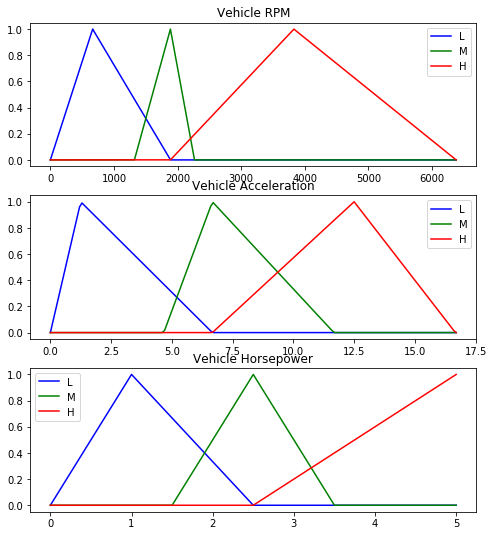

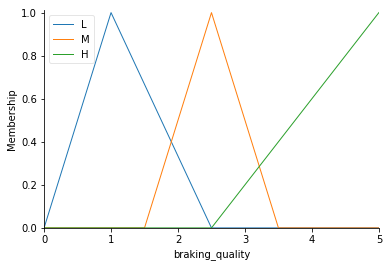

In [50]:
m = flModel(test_df)

m.compute_brake(1, 100)

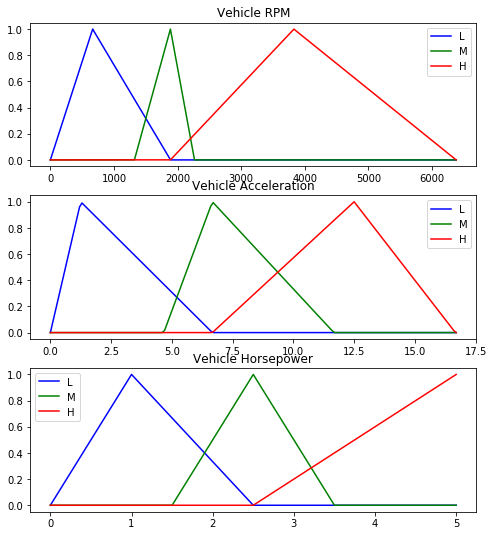

In [32]:
m = flModel(test_df)
with open('models/fuzzy_models.p', 'wb') as handle:
    pickle.dump(m, handle, protocol=3)